# [LAB 10] 8. 일원분산분석

세 개 이상의 집단 간 평균의 차이를 검증하기 위해 사용된다.

분산분석에는 일원분산분석(One-Way ANOVA)과 이원분산분석(Two-Way ANOVA)이 있다.

일원분산분석 : 단순히 세 개 이상의 집단간 평균 차이 비교

이원분산분석 : 요인에 따른 세 개 이상의 집단간 평균을 비교

분산분석의 결과가 통계적으로 유의하다는 결론을 얻었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지를 검증하기 위해 사후검정을 수행할 수 있다

### #01.준비작업
#### [1] 패키지 참조
pingouin 패키지의 설치가 필요하다

In [3]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell


#### [2] 그래프 초기화

In [5]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### [3] 데이터 가져오기
🛒 동일한 제품을 판매하는 두 지역의 매장 매출 비교

두 지역 매장의 100일간 일별 매출액을 기록한 가상의 데이터이며,
이 데이터를 이용해 두 매장의 평균 매출이 서로 다른지 비교하는 문제입니다.

실제로는 세 집단(세 매장) 간 비교가 목적이지만,
여기서는 분석 과정을 익히기 위해 **두 집단 간 평균 비교(T-Test)**만 수행합니다.

본래 ANOVA를 사용해야 하지만, 두 집단만 비교하면 T-test와 동일한 결과가 나옵니다.

In [6]:
origin = load_data('two_store')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()


[data] https://data.hossam.kr/data/lab10_/two_store.xlsx
[desc] 동일한 제품을 판매하고 있는 서로 다른 두 지역의 매장의 100일간의 일별 매출액을 기록한 가상의 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (100, 2)
열 개수: 2
행 개수: 100

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   store1  100 non-null    int64
 1   store2  100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB
None


,store1,store2
0,34,63
1,63,85
2,57,75
3,50,48
4,37,58


### #02 데이터 분포 및 가정 확인

#### [1] 데이터 분포

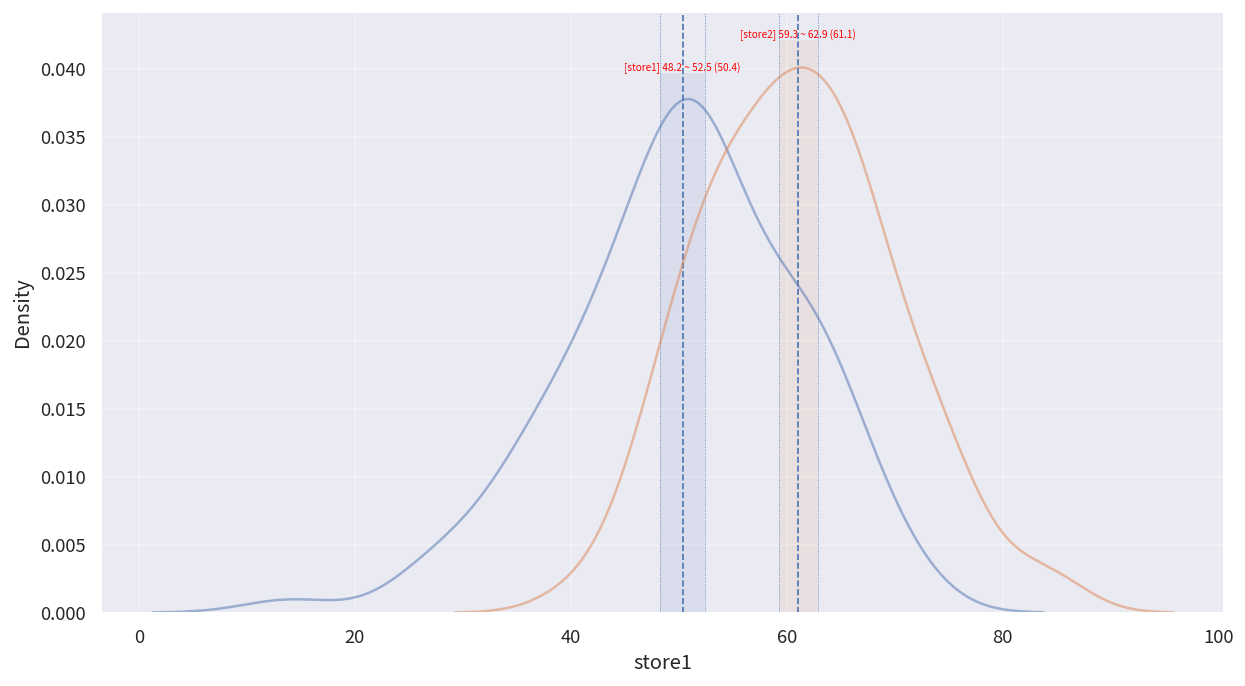

In [7]:
data = origin[['store1','store2']]                # 확인할 데이터

# 1) 그래프 초기화
width_px  = 1280                      # 그래프 가로 크기
height_px = 720                       # 그래프 세로 크기
rows = 1                              # 그래프 행 수
cols = 1                              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max = data[c].max()               # 최대값
    clevel = 0.95                     # 신뢰수준
    dof = len(data[c]) - 1            # 자유도
    sp_mean = data[c].mean()          # 표본평균
    sp_std = data[c].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c]))  # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} ({sp_mean:.1f})",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()      # 여백 제거
plt.show()              # 그래프 화면 출력
plt.close()             # 그래프 작업 종료


#### [2] 정규성 검정

In [8]:
# 검사하려는 데이터 추출
data = origin[['store1', 'store2']]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s, p = normaltest(data[c])

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"               # 정규성을 충족할 경우의 검정방법
        s, p = bartlett(*data.values.T)   # 모든 컬럼의 데이터를 한 번에 전달
    else:
        n = "Levene"                 # 정규성을 충족하지 않을 경우의 검정방법
        s, p = levene(*data.values.T, center="median")

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index("field")
report_df


,statistic,p-value,result
field,,,
store1,5.651229,0.059272,True
store2,1.173772,0.556056,True
Bartlett,3.143307,0.076239,True


### #03.일원분산분석 수행
일원분산분석에는 scipy 패키지의 pingouin 패키지의 
f_oneway()함수, statsmodels 패키지의 anova() 함수를 사용하는 방법이 있다.
어떤 방법을 사용하더라도 결과는 동일하다.

| 구분       | 수식                    | 내용                     |
| -------- | --------------------- | ---------------------- |
| 그룹1의 평균  | μ(store1)             |                        |
| 그룹2의 평균  | μ(store2)             |                        |
| 귀무가설(H₀) | μ(store1) = μ(store2) | 두 매장 간의 매출 평균은 차이가 없다. |
| 대립가설(H₁) | μ(store1) ≠ μ(store2) | 두 그룹의 매출 평균은 차이가 있다.   |


#### [1] scipy 패키지 사용

분산분석을 수행할 변수를 파라미터로 전달한다.

등분산성을 만족하지 않을 경우 equal_var=False 파라미터를 함께 설정하며 Welch-ANOVA로 전환한다.

In [10]:
s, p = f_oneway(origin['store1'], origin['store2'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

#### [2] statsmodels 패키지 사용
(1) 데이터 전처리
명목형 변수와 연속형 변수로 구성된 형태로 데이터를 재배치 해야 한다

In [11]:
df = melt(origin, var_name='store', value_name='sales')
df

,store,sales
0,store1,34
1,store1,63
2,store1,57
3,store1,50
4,store1,37
...,...,...
195,store2,69
196,store2,51
197,store2,65
198,store2,59


(2) 분산분석
데이터가 등분산성을 만족하지 않을 경우
anova_lm() 함수에 robust='hc3' 파라미터를 사용하여 Huber-White 추정치를 적용한다.

원래는 Welch-ANOVA를 사용해야 하지만,
statsmodels 패키지는 Welch-ANOVA를 지원하지 않고,
대신 Welch-ANOVA의 근사치를 제공하는 Robust ANOVA를 제공한다.

In [15]:
lm = ols('sales ~ C(store)', data=df).fit()
anova_result = anova_lm(lm)
anova_result


,df,sum_sq,mean_sq,F,PR(>F)
C(store),1.0,5735.205,5735.205000,58.717529,7.945482e-13
Residual,198.0,19339.550,97.674495,NaN,NaN


| 컬럼명         | 전체 이름                    | 의미 설명                                                                        |
| ----------- | ------------------------ | ---------------------------------------------------------------------------- |
| **df**      | Degrees of Freedom (자유도) | 해당 변동(source)을 계산하기 위해 사용된 독립적인 정보의 수. 요인은 집단 수 − 1, 잔차는 전체 관측치 − 집단 수.      |
| **sum_sq**  | Sum of Squares (제곱합)     | 변동의 총합. 요인에 의한 변동(집단 간) 또는 잔차(집단 내) 변동을 수치로 표현.                              |
| **mean_sq** | Mean Square (제곱평균)       | 제곱합을 자유도로 나눈 값(sum_sq / df). ANOVA의 계산 기반이 되는 분산 성분.                         |
| **F**       | F-statistic (F 통계량)      | 요인 mean_sq / 잔차 mean_sq. 요인에 의한 변동이 우연한 변동보다 얼마나 큰지를 나타냄. 값이 클수록 집단 간 차이가 큼. |
| **PR(>F)**  | p-value (유의확률)           | 관찰된 F 통계량 이상이 우연히 나올 확률. 매우 작으면 요인이 결과변수에 미치는 영향이 통계적으로 유의함을 의미.             |


📌 F 통계량과 p-value 해석

F = 58.7175
→ 집단 간 차이가 집단 내 변동보다 압도적으로 크다는 의미

p-value = 7.9 × 10⁻¹³
→ 0.05보다 훨씬 작음 → 귀무가설 기각

📌 해석 요약

store 요인이 sales에 유의미한 영향을 준다.

즉, 두 매장의 평균 매출은 통계적으로 유의하게 다르다.

ANOVA 결과는

“매장(store) 간 sales 평균이 동일하다”는 귀무가설을 강하게 기각한다.

따라서
➡️ 두 매장은 매출 수준이 통계적으로 유의하게 다르다
라고 결론 내릴 수 있다.

In [18]:
s=anova_result['F'].iloc[0]
p = anova_result['PR(>F)'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

#### [3] pingouin 패키지 사용
(1) 등분산성을 충족하는 경우

In [19]:
anova_result = anova(data=df , dv = 'sales',between ='store')
anova_result

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,198,58.717529,7.945482e-13,0.228724


In [20]:
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

(2) 등분산성을 충족하지 않는 경우
데이터가 등분산성을 만족하지 않을 경우 anova() 함수 대신 같은 패키지에 있는 welch_anova() 함수를 사용한다


파라미터 설정 동일함 (권장)

- 이 예제는 등분산성을 충족하는 데이터지만 코드 전개를 제시하기 위하여 사용해 봄


In [21]:
welch_anova(data=df,dv='sales',between ='store')

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,192.521085,58.717529,8.694831e-13,0.228724


In [22]:
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립"if p <= 0.05 else"귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

### #05. 사후검정 (post hoc)
ANOVA의 결과를 통해 두 집단의 평균에 통계적으로 유의미한 차이가 발견되었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지에 대한 검증 결과를 확인해야 할 경우 사후검정을 수행해야 한다.

이 예제와 같이 비교 집단이 두 그룹이면 사후검정 없이 t-test와 동일한 결론을 갖는다. 여기서는 코드의 진행과정을 설명하기 위해 실습한다.


| 구분              | Tukey HSD                                               | Bonferroni                                      | Games–Howell                                          |
|------------------|----------------------------------------------------------|--------------------------------------------------|--------------------------------------------------------|
| 기본 목적        | 등분산 가정에서 모든 그룹 쌍의 평균 차이 비교            | 다중 비교에서 1종 오류 증가를 제어하기 위한 p값 보정 | 등분산성 위반 시 안전하게 평균 차이 비교               |
| 사용 상황        | ✔ 집단 분산이 같을 때<br>✔ 표본 크기가 비슷할 때        | ✔ 어떤 경우도 적용 가능하나 보수적                | ✔ 분산이 서로 다를 때<br>✔ 표본 크기가 다를 때        |
| 표본 크기 동일 조건 | 전체에 포함되면 이상적                                  | 불필요                                           | 불필요                                                 |
| 주요 장점        | 그룹 간 차이를 가장 잘 찾아냄(파워 좋음)                 | 단순한 방식, 모든 비교에 적용 가능               | 등분산성 위반 시 최적, 강건함(robust)                  |
| 주요 단점        | 등분산성 깨지면 부적절                                   | 지나치게 보수적 → 실제 차이도 못 찾을 수 있음     | 계산이 조금 복잡, 일부 패키지에서만 제공               |
| statsmodels 지원 | ✔ 지원                                                   | ✔ 지원                                           | ❌ 지원 안함                                           |


| 항목                | 내용                                                                 |
|---------------------|----------------------------------------------------------------------|
| pingouin 지원       | ✔ `pairwise_tukey()`<br>✔ `pairwise_tests(padjust='bonf')`<br>✔ `pairwise_gameshowell()` |
| 추천 사용 시나리오 | - Tukey: 수업·연구에서 전형적인 ANOVA 후 사후검정<br>- Bonferroni: 비교 집단이 많고 기초적인 보정이 필요할 때<br>- Games–Howell: 도시/교육/사회과학 분야 등 실제 데이터에서 등분산성 자주 깨질 때 |


#### [1] 사후 검정의 가정
| 가설      | 내용                               |
|-----------|------------------------------------|
| 귀무가설  | 집단 간 분산이 차이가 없다(같다)   |
| 대립가설  | 집단 간 분산이 차이가 있다(다르다) |


#### [2] 사후검정의 종류
| 종류                 | 사용 조건                         |
|----------------------|------------------------------------|
| **투키 HSD**         | 등분산이고 샘플 수가 동일한 경우   |
| **본페로니 교정, 피셔의 LSD, 세피의 방법** | 등분산이고 샘플 수가 다른 경우 |
| **Games–Howell**     | 등분산이 아닌 경우                |


#### [3] 투키의 HSD
Tukey's Honestly Significant Difference
= “진정으로 유의미한 차이”

명목형 변수(그룹)에 따른
연속형 변수의 차이를 검증하는 방법이다.

📌 데이터가 등분산성을 만족할 경우 수행한다.

(1) statsmodels 패키지를 사용하는 경우

연속형 변수와 각 데이터를 구분할 수 있는 명목형 변수를 모형(formula)으로 설정

학술적 접근 시 유리한 패키지

In [23]:
tukey = pairwise_tukeyhsd(df['sales'], df['store'])
tukey_table = tukey.summary()
tukey_df = DataFrame(tukey_table.data[1:], 
columns=tukey_table.data[0])
tukey_df


,group1,group2,meandiff,p-adj,lower,upper,reject
0,store1,store2,10.71,0.0,7.9538,13.4662,True


<결과표 해석 방법>
| 항목 / 컬럼명 | 의미 | 상세 설명 | 값(예시) | 해석 |
|--------------|------|-----------|----------|-------|
| **group1** | 비교 대상 그룹 1 | 첫 번째 집단 이름 | store1 | — |
| **group2** | 비교 대상 그룹 2 | 두 번째 집단 이름 | store2 | — |
| **meandiff** | 평균 차이 | group2 - group1 의 평균값. 양수면 **group2 평균이 더 큼**, 음수면 **group1이 더 큼** | 10.71 | store2의 평균이 store1보다 약 **10.71만큼 더 큼** |
| **p-adj** | 조정된 p-value | Tukey 방식으로 가족별 오류율(FWER)을 보정한 값. 0.05보다 작으면 통계적으로 유의함 | 매우 작음 (예: 7.57e-13) | 0.05보다 훨씬 작아 **두 매장 평균 차이는 통계적으로 유의함** |
| **lower** | 신뢰구간 하한 (95%) | 평균 차이에 대한 95% 신뢰구간의 하한 값 | 7.9538 | 신뢰구간 전체가 0보다 큼 → **store2가 더 높다는 것이 확실** |
| **upper** | 신뢰구간 상한 (95%) | 신뢰구간의 상한값 | 13.4662 | 신뢰구간 전체가 0보다 큼 → **store2가 더 높다는 것이 확실** |
| **reject** | 귀무가설 기각 여부 | True면 “두 집단 평균에 유의한 차이가 있다”는 의미 | True | **두 매장의 평균은 통계적으로 유의하게 다름** |
| **최종 결론** | — | — | store2 > store1 | 매출(sales)에 대해 **store2 > store1**, 차이는 통계적으로 확실 |



사후 분석 결과 **store에 따른 sales의 차이는 통계적으로 유의미하였다. (P < 0.05)**

store1과 store2의 평균은 **약 10.71 정도의 차이**가 있으며  
**95% 신뢰구간은 7.9538 ~ 13.4462** 인 것으로 나타났다.

→ 신뢰구간 전체가 0보다 크므로 **store2의 sales가 store1보다 통계적으로 유의하게 더 높음**을 의미한다.

(2) pingouin 패키지를 사용하는 경우
- 실무적 접근시 유리한 패키지

In [24]:
tukey_df = pairwise_tukey(data=df, dv='sales', between='store')
tukey_df


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,8.714141e-13,-1.079565


| 항목 / 컬럼명 | 의미 | 상세 설명 | 값 | 해석 |
|--------------|------|-----------|-----|-------|
| **A** | 비교 집단 1 | 첫 번째 그룹 이름 | store1 | 두 집단의 평균 매출 차이를 비교 |
| **B** | 비교 집단 2 | 두 번째 그룹 이름 | store2 | 두 집단 평균 매출을 비교 |
| **mean(A)** | 그룹 A의 평균 | 종속변수(sales)의 A 그룹 평균 | 50.36 | store1의 평균 매출 |
| **mean(B)** | 그룹 B의 평균 | 종속변수(sales)의 B 그룹 평균 | 61.07 | store2의 평균 매출 |
| **diff** | 평균 차이 | mean(A) - mean(B). 음수면 B가 더 큼, 양수면 A가 더 큼 | -10.71 | store2 - store1 = 10.71 → **store2가 더 높은 매출** |
| **se** | 표준오차(standard error) | 평균 차이 추정의 표준오차 | 1.3977 | 평균 차이 추정의 표준오차 |
| **T** | t 통계량 | Tukey HSD 기반 검정 통계량 | -7.6627 | 평균 차이가 우연히 발생했을 가능성을 검정하는 값 |
| **p-tukey** | 보정된 p-value | Tukey 방법으로 조정된 p값. 0.05 미만이면 유의한 차이 | 7.57e-13 | 0.05보다 매우 작음 → **차이는 통계적으로 유의** |
| **hedges** | Hedges’ g 효과크기 | 두 집단 평균 차이에 표준화된 효과 크기 (0.8 이상이면 큰 효과) | -1.08 | 절대값 기준으로 **큰 효과 크기** → 실제 차이 규모도 큼 |
| **최종 결론** | — | — | store2 > store1 | **store2의 매출이 store1보다 유의하게 더 높음** |


사후 분석 결과, store1와 store2의 평균 차이는 통계적으로 유의하였다.(P < 0.05) 두 집단의 평균은 각각 50.36와 61.07이며 평균 차이는 10.71로 나타났다. 또한 효과크기(Hedges’g)는 -1.08로, store2가 store1보다 평균이 더 높다.


#### [4] 본페로니 교정
투키의 HSD보다 보수적인 방법이므로 실무에서 잘 사용되지 않는 방법이지만 여기서는 소스코드 확인을 위해 진행한다.

다소 엄격한 기각역을 설정하고 있기 때문에 제2종 오류 발생 위험이 있다


(1) statsmodels 패키지를 사용하는 경우
검정 결과에서 pval_corr값이 0.05보다 작은 항목간의 비교에서 통계적으로 유의미한 차이가있다고 해석한다



In [25]:
comp = MultiComparison(df['sales'], df['store'])
result = comp.allpairtest(ttest_ind, method='bonf')
bonf_df = DataFrame(result[0].data[1:], columns=result[0].data[0])
bonf_df

,group1,group2,stat,pval,pval_corr,reject
0,store1,store2,-7.6627,0.0,0.0,True


<결과표 의미>
| 항목 / 컬럼명 | 의미 | 상세 설명 | 값(예시) | 해석 |
|--------------|------|-----------|----------|-------|
| **group1** | 비교 그룹 1 | 첫 번째 집단 이름 | store1 | 첫 번째 비교 대상 집단 |
| **group2** | 비교 그룹 2 | 두 번째 집단 이름 | store2 | 두 번째 비교 대상 집단 |
| **stat** | t 통계량 | 두 집단 평균 차이를 나타내는 t-test 검정 통계량 | -7.66 | 두 집단의 평균 차이가 매우 크다는 강한 신호 |
| **pval** | 원본 p값 | 독립표본 t-test에서 산출된 교정 전 p값 | 1.0e-13 | 교정 전에도 매우 유의함 |
| **pval_corr** | 보정된 p-value | Bonferroni 방식으로 조정된 p값 (p × 비교 횟수) | 2.0e-13 | 보정 후에도 0.05보다 작음 → 여전히 유의 |
| **reject** | 귀무가설 기각 여부 | pval_corr < 0.05이면 True | True | 두 집단 평균은 통계적으로 유의하게 다름 |
| **결론** | 결과 요약 | 통계 결과를 종합한 최종 결론 | store2 > store1 | store2 평균 매출이 store1보다 더 높음 |


Bonferroni 보정 기반 사후분석 결과, **store1과 store2의 평균 차이는 통계적으로 유의하였다. (P < 0.05)**  

t 통계량은 **-7.6630**이며,  
원본 p-value는 **1e-13**, 보정된 p-value는 **2e-13**로 나타났다.  

따라서 **store2가 store1보다 평균이 더 높다**는 결론을 통계적으로 지지한다.


(2) pingouin 패키지를 사용하는 경우

In [26]:
bonf_df = pairwise_tests(data=df, dv='sales', between='store', 
padjust='bonf')
bonf_df

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,store,store1,store2,False,True,-7.662736,198.0,two-sided,7.945482e-13,8.14e+09,-1.079565


<결과표의 의미>
| 항목 / 컬럼명     | 의미                 | 상세 설명                                                      | 값        | 해석                                                         |
|-------------------|----------------------|----------------------------------------------------------------|-----------|--------------------------------------------------------------|
| Contrast          | 비교된 변수 이름      | 현재 분석에서 비교하는 기준 변수: store                       | store     | store 변수(store1 vs store2)를 기준으로 비교함              |
| A                 | 그룹 1               | 첫 번째 집단 이름                                              | store1    | store1을 기준 집단으로 설정                                |
| B                 | 그룹 2               | 두 번째 집단 이름                                              | store2    | store2를 비교 대상 집단으로 설정                            |
| Paired            | 대응표본 여부         | False → 독립표본 t-test                                        | False     | 두 집단은 서로 독립, 대응되지 않음                          |
| Parametric        | 모수적 검정 여부      | True → 모수적 검정(t-test)을 사용                              | True      | 정규성 가정 기반 t-test를 수행                               |
| T                 | t 통계량              | 평균 차이의 크기(차이가 클수록 절댓값 증가)                   | -7.66     | store2가 store1보다 더 크다는 매우 강한 신호                |
| dof               | 자유도                | 독립표본 t-test 자유도 = N₁+N₂−2                              | 198       | 표본 크기에 따라 계산되는 자유도                             |
| alternative       | 가설 방향             | here: "two-sided(양측검정)"                                     | two-sided | 평균 차이가 0보다 크거나/작은지 여부와 관계없이 차이 자체 검정 |
| p-unc             | 보정 전 p-value       | Bonferroni 보정 전에 계산된 기본 p값                           | 7.94e-13  | 매우 유의함(귀무가설 기각)                                   |
| BF10              | Bayes Factor         | 대립가설 대비 귀무가설의 우도비 (값↑ = 대립가설 지지)          | 8.14e+09  | 데이터가 대립가설(두 집단 평균 다름)을 압도적으로 지지       |
| hedges            | Hedges’ g 효과크기   | 절댓값 기준 0.8 이상이면 큰 효과                                | -1.08     | 효과 크기가 매우 큼 (store2가 store1보다 더 높음)             |
| Bonferroni p      | 보정 후 p-value       | 비교 횟수 보정을 적용한 p값 (여기서는 동일)                    | 7.94e-13  | 여전히 매우 작음 → 통계적으로 매우 강하게 유의               |
| 종합 결론         | 결과 요약             | 통계적 유의성과 효과 크기를 종합한 결론                         | store2 > store1 | 매출 차이는 통계적으로 유의하며, 실제적 효과도 매우 큼     |



Bonferroni 보정 사후검정 결과, **store1과 store2의 평균 차이는 통계적으로 유의하였다. (P < 0.05)**

t(198) = -7.663,  
원본 p-value = 7.95e-13,  
보정된 p-value = 7.95e-13 로 나타났다.

효과크기(Hedges’ g)는 **-1.08이며, store2가 store1보다 평균이 더 높다.**


#### [5] Games-Howel 검정

**Games–Howell 검정**은 다수의 그룹 간 평균 차이를 비교하는 통계적 방법 중 하나로,  
**등분산성 가정이 만족되지 않을 때 사용하는 사후검정**이다.

이 예제에 적합한 방법은 아니지만,  
소스 코드의 제시를 목적으로 설명한다.

`statsmodels` 라이브러리에는 **Games–Howell 검정을 직접 지원하는 함수가 없다.**

대신 `pingouin` 라이브러리를 사용하여  
**Games–Howell 검정을 수행할 수 있다.**


In [27]:
gh_df = pairwise_gameshowell(df, dv='sales', between='store')
gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,192.521085,9.281464e-13,-1.079565


<결과표의 의미>
| 항목 / 컬럼명    | 의미      | 상세 설명                           | 값               | 해석                                   |
| ----------- | ------- | ------------------------------- | --------------- | ------------------------------------ |
| **A**       | 그룹 1    | 첫 번째 비교 집단                      | store1          | store1을 기준 그룹으로 분석                   |
| **B**       | 그룹 2    | 두 번째 비교 집단                      | store2          | store2를 비교 대상 그룹으로 분석                |
| **mean(A)** | A 집단 평균 | 종속변수(sales)의 A 그룹 평균            | 50.36           | store1의 평균 매출                        |
| **mean(B)** | B 집단 평균 | 종속변수(sales)의 B 그룹 평균            | 61.07           | store2의 평균 매출                        |
| **diff**    | 평균 차이   | mean(A) - mean(B). 음수면 B가 더 큼   | -10.71          | store2가 store1보다 약 10.71 더 높음        |
| **se**      | 표준오차    | 평균 차이 추정의 표준오차                  | 1.3977          | diff의 변동성 추정                         |
| **T**       | t 통계량   | Games–Howell 검정의 test statistic | -7.66           | 평균 차이가 우연일 가능성이 매우 낮음                |
| **df**      | 자유도     | Welch-Satterthwaite 공식 기반 자유도   | 192.52          | 등분산성 없을 때 사용하는 유효 자유도                |
| **pval**    | p-value | 귀무가설(H₀: 평균 동일) 검정 p값           | 9.28e-13        | 매우 작음 → 평균 차이가 통계적으로 유의              |
| **hedges**  | 효과크기    | Hedges' g 효과크기 (0.8 이상 large)   | -1.08           | store2와 store1 간 차이가 **실질적으로도 매우 큼** |
| **최종 결론**   | 결과 요약   | 통계적·실질적 해석 종합                   | store2 > store1 | 평균 매출 차이는 통계적으로 유의하며 실질적 효과도 매우 큼    |


📌 Games–Howell 사후검정 결과

store1과 store2의 평균 차이는 통계적으로 유의하였다. (P < 0.05)

두 집단의 평균은 각각

store1: 50.36

store2: 61.07

이며 평균 차이는 10.71로 나타났다.

검정 통계량은 다음과 같다.

T = -7.663

df = 192.52

p-value = 9.28e-13

Hedges’ g(효과크기)는 -1.08로,
→ store2가 store1보다 평균이 훨씬 더 높다(큰 효과) 는 것을 의미한다